In [12]:
import data_loader as dl
loader = dl.DataLoader('./data')
df = loader.get('20191001')

/home/artem/Documents/GitHub/forecast-exchange/data_loader.py:32: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  df = pd.DataFrame(data.value, columns=[i.decode('utf-8') for i in ob.value])


In [2]:
import torch
from torch import nn

In [20]:
import fastai
from fastai import tabular
path = tabular.ItemList.from_folder('./data', recurse=True, extensions=['.h5py'])
path

ItemList (31 items)
data/20191013/data.h5py,data/20191026/data.h5py,data/20191009/data.h5py,data/20191004/data.h5py,data/20191005/data.h5py
Path: data

# Обработка входных данных

In [4]:
def param_padding(x, target_shape):
    if x.shape == target_shape:
        return x
    n, m = x.shape
    new_n, _ = target_shape
    if n > new_n:
        return x[:new_n - n, :]
    else:
        mean_value = x.mean(axis=0)
        pad_part = np.ones((new_n - n, 1)) @ mean_value.reshape(1, m)
        result = np.zeros(target_shape)
        result[:n, :] = x[::-1, :]
        result[n:, :] = pad_part
        return result


In [5]:
it = df_exchange[df_exchange.exchange == 1.0].groupby('received_time')
x = [v.drop(columns=['received_time', 'exchange']).values for _, v in it]
lens = [i.shape for i in x]
max_len = max(lens)
x = [param_padding(i, max_len) for i in x]
x_inds = [i for i, _ in it]

NameError: name 'df_exchange' is not defined

# Обработка возвращаемых значений

In [6]:

it = df_price[df_price.exchange == 1.0].drop(columns=['exchange']).groupby('received_time')
y_dict = {i: v.tr_price.mean() for i, v in it}
y = torch.tensor([y_dict[i] for i in x_inds if i in y_dict])

NameError: name 'df_price' is not defined

In [7]:
x = torch.tensor([v for i, v in zip(x_inds, x) if i in y_dict])

NameError: name 'x_inds' is not defined

In [23]:
import torch
import numpy as np
from torch import nn

In [91]:
class TestModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq1 = nn.Sequential(
            nn.Linear(20, 10),
            nn.PReLU(),
            nn.Linear(10, 5),
            nn.PReLU(),
            nn.Linear(5, 1),
            nn.PReLU(),
        )

        self.seq2 = nn.Sequential(
            nn.Linear(35, 16),
            nn.PReLU(),
            nn.Linear(16, 8),
            nn.PReLU(),
            nn.Linear(8, 4),
            nn.PReLU(),
            nn.Linear(4, 1),
        )
    
    def forward(self, x):
        n, _, _ = x.shape
        x = self.seq1(x)
        x = x.reshape(n, 35)
        x = self.seq2(x)
        return x.reshape(n)

model = TestModel()

In [67]:
import fastai
from torch.utils import data
import data_loader as dl

from sklearn.utils import shuffle

x, y = dl.prepare_data(df, 1)
x, y = x.numpy(), y.numpy()
df_train = dl.ArrayDataset(x, y, 1)
validation_split = .15

dataset_size = len(df_train)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
x, y = shuffle(x, y)

x_valid, x_train = torch.from_numpy(x[:split]).float(), torch.from_numpy(x[split:]).float()
y_valid, y_train = torch.from_numpy(y[:split]).float(), torch.from_numpy(y[split:]).float()

In [68]:
ds_train = dl.ArrayDataset(x_train, y_train, 1)
ds_valid = dl.ArrayDataset(x_valid, y_valid, 1)

In [92]:
data_bunch = fastai.basic_data.DataBunch.create(ds_train, ds_valid, device=torch.device('cuda'), bs=256)
leaner = fastai.basic_train.Learner(data_bunch, model, loss_func=nn.MSELoss())

In [94]:
leaner.fit(20)
# leaner.fit(1)
# nn.SmoothL1Loss(model(x.cuda()), y.cuda())
# y.shape, model(x.cuda()).shape

# x, y = data_bunch.one_batch()
# print(model(x.cuda()))

In [73]:
# leaner.fit(10)
for i in leaner.data.train_dl:
    print(i)
    break
# data_bunch.one_batch()

[tensor([[[8.3408e+03, 8.3411e+03, 8.3417e+03,  ..., 4.5000e-02,
          5.8100e-01, 4.9900e-01],
         [8.3408e+03, 8.3411e+03, 8.3414e+03,  ..., 1.0000e-02,
          4.5000e-02, 4.0000e-02],
         [8.3408e+03, 8.3411e+03, 8.3417e+03,  ..., 1.0000e-02,
          4.5000e-02, 5.8100e-01],
         ...,
         [8.3420e+03, 8.3424e+03, 8.3425e+03,  ..., 4.8241e+00,
          1.5740e-02, 9.9078e-02],
         [8.3420e+03, 8.3424e+03, 8.3425e+03,  ..., 2.3972e-03,
          1.1982e-02, 4.8241e+00],
         [8.3414e+03, 8.3416e+03, 8.3419e+03,  ..., 1.5488e+00,
          2.2098e+00, 1.6123e+00]],

        [[8.2475e+03, 8.2476e+03, 8.2478e+03,  ..., 3.5600e-01,
          7.7000e-02, 3.5600e-01],
         [8.2476e+03, 8.2477e+03, 8.2478e+03,  ..., 2.1693e-03,
          9.9990e-03, 3.2000e-02],
         [8.2476e+03, 8.2477e+03, 8.2478e+03,  ..., 4.5000e-02,
          6.0600e-01, 2.4252e-03],
         ...,
         [8.2668e+03, 8.2670e+03, 8.2671e+03,  ..., 6.0000e-03,
          8.41

In [53]:
x, y = data_bunch.one_batch()
x.shape, y.shape

(torch.Size([256, 35, 20]), torch.Size([256]))

In [30]:
# from datetime import datetime
import numpy as np
x = np.array(sorted(set(df.received_time.apply(int) // 30000)))
x[1:] - x[:-1]
x.shape[0]/2/60/24

1.0118055555555556

In [43]:
from datetime import datetime

(df.received_time / 1000).apply(datetime.fromtimestamp)
# print(df.received_time[0] / 1000 - time.time())
# datetime.fromtimestamp(df.received_time[0] / 1000)

1576245036.2899241


0         2019-10-01 10:06:03.708
1         2019-10-01 10:06:03.791
2         2019-10-01 10:06:03.791
3         2019-10-01 10:06:04.016
4         2019-10-01 10:06:04.118
                    ...          
1084683   2019-10-02 10:22:32.452
1084684   2019-10-02 10:22:33.353
1084685   2019-10-02 10:22:34.225
1084686   2019-10-02 10:22:35.089
1084687   2019-10-02 10:22:36.019
Name: received_time, Length: 1084688, dtype: datetime64[ns]

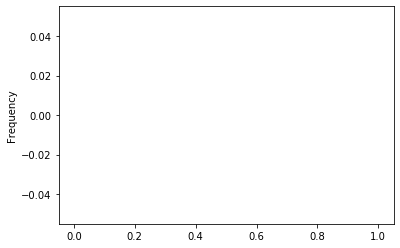

In [19]:
df.tr_side[df.update_type.apply(int) == 1]

In [49]:
data = df[df.update_type > 0.5].filter(items=['received_time', 'tr_price', 'tr_side', 'tr_size', 'update_type'])


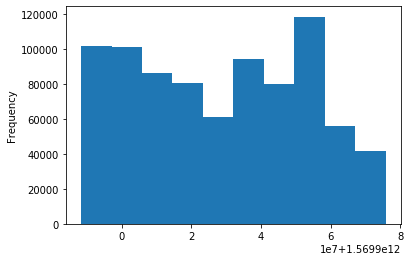

In [54]:
# (data.received_time // 30000).value_counts()
data.received_time.plot.hist()

In [51]:
import torch
import fastai
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

class RegressionModel(torch.nn.Module):
    